In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import init_session
init_session()
from sympy.matrices import Matrix, eye, zeros, ones, diag
from sympy.plotting import plot3d
from mpl_toolkits.mplot3d import Axes3D
out_dir='/home/fcaimmi/Documents/Politecnico/Didattica/Composite_materials_for_structural_applications/Lezioni Compositi/2016-LECTURES/design_examples/'

IPython console for SymPy 0.7.6 (Python 2.7.6-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://www.sympy.org


In [2]:
fi = symbols('fi')
c = cos(fi)
s = sin(fi)
#material stiffness matrix in the principal material reference system
Q11, Q12, Q22, Q66 = symbols('Q11 Q12 Q22 Q66')
Q = Matrix([[Q11, Q12,0],[Q12,Q22,0],[0,0,Q66]])
#transformation matrices
T = Matrix([[c**2, s**2, 2*c*s],[s**2,c**2,-2*c*s],[-c*s,c*s,c**2-s**2]])
R = Matrix([[1,0,0],[0,1,0],[0,0,2]])
Te = R*T*R**-1
#stiffness matrix in the global reference system
QXY=eye(3)
QXY[0,0] = Q11*c**4+Q22*s**4+(2*Q12+4*Q66)*c**2*s**2
QXY[0,1] = Q12*(c**4+s**4)+(Q11+Q22-4*Q66)*c**2*s**2
QXY[1,0] = QXY[0,1]
QXY[1,1] = Q11*s**4+Q22*c**4+(2*Q12+4*Q66)*c**2*s**2
QXY[0,2] = (Q11-Q12-2*Q66)*c**3*s-(Q22-Q12-2*Q66)*c*s**3
QXY[1,2] = (Q11-Q12-2*Q66)*c*s**3-(Q22-Q12-2*Q66)*c**3*s
QXY[2,2] = (Q11+Q22-2*Q12-2*Q66)*c**2*s**2+Q66*(c**4+s**4)
QXY[2,0] = QXY[0,2]
QXY[2,1] = QXY[1,2]
#A matrix
h_phi, h_0 = symbols('h_phi h')
heights = [h_0,h_phi,h_phi,h_phi,h_phi,h_0]
angles = [0,fi,-fi,-fi,fi,0]
A = zeros(3,3)
for l in xrange(len(heights)):
    Q_prime = QXY.subs(fi,angles[l])
    for i in xrange(3):
        for j in xrange(3):
            A[i,j]=A[i,j]+Q_prime[i,j]*heights[l]
A.simplify()
#Thermal expansion tensor
alpha_1, alpha_2 = symbols('alpha_1 alpha_2')
alphaXY = Matrix([alpha_1*c**2+alpha_2*s**2,alpha_1*s**2+alpha_2*c**2,2*(alpha_1-alpha_2)*c*s])
#U matrix
U = Matrix([0,0,0])
for l in xrange(len(heights)):
    Q_prime = QXY.subs(fi,angles[l])
    alpha_prime = alphaXY.subs(fi,angles[l])
    S = Q_prime*alpha_prime
    for i in xrange(3):
        U[i]=U[i]+S[i]*heights[l]
U.simplify()
#u vector
u = A**-1*U
u.simplify()
a_X = u[0]

In [3]:
#materiale T300/5208 (letteratura)
title = 'T300/5208'
C = Matrix([[1/181000,-0.28/181000,0],[-0.28/181000,1/10300,0],[0,0,1/7170]])
q = C**-1
gensub = {h_phi:3/2-h_0/2, Q11: q[0,0],Q12: q[0,1], Q22: q[1,1], Q66: q[2,2],alpha_1:0.02e-6,alpha_2:22.5e-6}
    

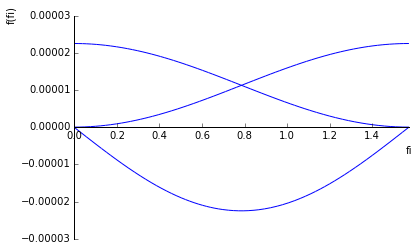

In [4]:
#plot T300 coefficienti espansione termica al variare dell'angolo
f = alphaXY.subs(gensub)
plot(f[0],f[1], f[2],(fi,0,pi/2))
fn = lambdify(fi,f,"numpy")
x = np.linspace(0,np.pi/2,100)
d = np.zeros((len(x),4))
for i in range(len(x)):
    d[i] = [x[i],1e6*fn(x[i])[0,0],1e6*fn(x[i])[1,0],1e6*fn(x[i])[2,0]]
header = ['theta [rad]','alphax*1e6','alphay*1e6','alphaxy*1e6']
np.savetxt('alpha_vs_theta.txt',d, delimiter='\t',header = '\t'.join(header))

In [17]:
f=a_X.subs(gensub)

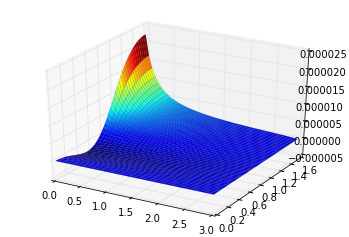

sympy.plotting.plot.Plot

In [18]:
figura=plot3d(f,(h_0,0,3),(fi,0,pi/2),zlim=(-1e-5,1e-5))
type(figura)


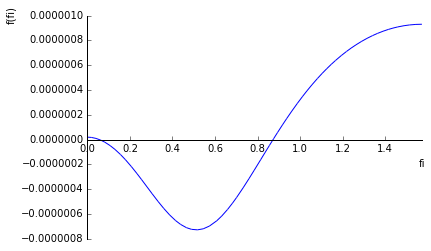

In [19]:
#grafico di una sezione ad h fissato
g = f.subs({h_0:2});g
plot(g.subs(0,h_0),(fi,0,pi/2))

In [34]:
#sympy non mi fa fare il plot del contorno...converti in espressione vettorizzata e passa a numpy
fn = lambdify((h_0,fi),f,"numpy")
npts=25
x = np.linspace(0,3,npts)
y = np.linspace(0,np.pi/2,npts)
X,Y = np.meshgrid(x,y)
Z = fn(X,Y)
#export the data
output = np.column_stack((np.ravel(X),np.ravel(Y),np.ravel(Z)))
np.savetxt(out_dir+'thermal_data.txt',output, delimiter='\t')

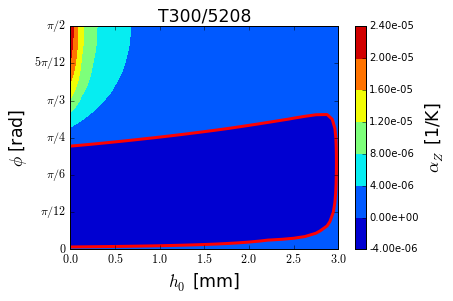

In [47]:
#plot the results
plt.figure()
cs=plt.contourf(X,Y,Z)
lev = cs.levels
collections = cs.collections
for coll in collections:
    vert = coll.get_paths()[0].vertices
#prepare output
with open(out_dir+'thermal_contours.txt','a') as outfile:
    for i in range(len(collections)):
        vert = collections[i].get_paths()[0].vertices
        output=np.column_stack((vert,lev[i]*np.ones(vert.shape[0])))
        np.savetxt(outfile,output,delimiter='\t')
        outfile.write('\n')
#prepare labels for the angle axis
nlabels = 7
positions = np.linspace(0,np.pi/2,nlabels)
deltafi = pi/2/(nlabels-1)
labels = [0 for i in range(nlabels)]
for i in range(len(labels)-1):
    labels[i+1] = labels[i]+deltafi
labels = ['$'+(str(word)).replace('pi','\\pi').replace('*','')+'$' for word in labels]
#add decorations to the plot
plt.xlabel('$h_0$ [mm]', fontsize = 'xx-large')
plt.ylabel('$\phi$ [rad]', fontsize = 'xx-large')
plt.xticks(np.linspace(0,3,7),['$'+str(i)+'$' for i in np.linspace(0,3,7)],fontsize ='large')
plt.yticks(positions,labels, fontsize ='large')
cb = plt.colorbar(format='%.2e')
cb.set_label('$\\alpha_Z$ [1/K]',fontsize = 'xx-large' )
#plot the line at zero level
cs=plt.contour(X,Y,Z,0, colors = 'r', linewidths=3)
zero_data=cs.collections[0].get_paths()[0].vertices
output= np.column_stack((zero_data,np.zeros(zero_data.shape[0])))
np.savetxt(out_dir+'thermal_zero.txt',output, delimiter='\t')
plt.title(title,fontsize = 'xx-large')
plt.savefig(out_dir+title.replace('/','_')+'_design_space.png',dpi=300, bbox_inches = 'tight')

In [42]:
#find an angle for a given height
from scipy.optimize import newton
h0=0.5
def pol(h):
    def f(fi):
        return fn(h,fi)
    return f
root = pol(h0)
angle = np.rad2deg(newton(root, 0.8))
angle

In [60]:
#find an optimal height for a given angle
angle = np.pi/3
from scipy.optimize import newton
def pol2(fi):
    def f(h):
        return fn(h,fi)
    return f
root = pol2(angle)
height = newton(root, 1.5)
height